In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv(r'/home/saswata/data_science/UM_projects/world_population/world_population.csv')
df

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,226,WLF,Wallis and Futuna,Mata-Utu,Oceania,11572,11655,12182,13142,14723,13454,11315,9377,142,81.4930,0.9953,0.00
230,172,ESH,Western Sahara,El Aaiún,Africa,575986,556048,491824,413296,270375,178529,116775,76371,266000,2.1654,1.0184,0.01
231,46,YEM,Yemen,Sanaa,Asia,33696614,32284046,28516545,24743946,18628700,13375121,9204938,6843607,527968,63.8232,1.0217,0.42
232,63,ZMB,Zambia,Lusaka,Africa,20017675,18927715,16248230,13792086,9891136,7686401,5720438,4281671,752612,26.5976,1.0280,0.25


In [3]:
import pandas as pd

# --- Melt the Data ---
pop_cols = [col for col in df.columns if 'Population' in col and 'World' not in col]
df_melted = df.melt(
    id_vars=['Country/Territory', 'Area (km²)', 'Growth Rate'],
    value_vars=pop_cols,
    var_name='Year',
    value_name='Population'
)
df_melted['Year'] = df_melted['Year'].str.extract(r'(\d{4})').astype(int)
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-01-01')  # Set date as 1st Jan of each year
df_melted.sort_values(by=['Country/Territory', 'Date'], inplace=True)

# --- Feature Engineering ---
df_melted['Density'] = df_melted['Population'] / df_melted['Area (km²)']

# Initialize Growth and Growth Rate Δ with NaN
df_melted['Growth'] = pd.NA

# Set Growth and Growth Rate Δ for the first year (1970) as 0
df_melted.loc[df_melted['Year'] == 1970, 'Growth'] = 0

# Calculate Growth and Growth Rate Δ, starting from 1971 (second year)
for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].sort_values(by='Year').copy()
    
    # Calculate Growth (change in population relative to previous year) and Growth Rate Δ (difference of Growth)
    for i in range(1, len(country_df)):
        current_year = country_df.iloc[i]
        previous_year = country_df.iloc[i-1]
        
        # Calculate Growth Rate (change in population from previous year to current year)
        growth_rate = (current_year['Population'] - previous_year['Population']) / previous_year['Population']
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == current_year['Year']), 'Growth'] = growth_rate
        


# --- Extrapolation for 1970 ---
# After calculating growth for subsequent years, we can extrapolate growth for the first year.
# We'll simply carry forward the second year’s growth and growth rate change to the first year.

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()
    
    # Extrapolate growth and rate of change of growth rate from second year to the first year
    if 1971 in country_df['Year'].values:
        growth_2nd_year = country_df[country_df['Year'] == 1971]['Growth'].values[0]
        
        # Extrapolate using 2nd year's values for the first year
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == 1970), 'Growth'] = growth_2nd_year

df_melted.head(20)

,Country/Territory,Area (km²),Growth Rate,Year,Population,Date,Density,Growth
1638,Afghanistan,652230,1.0257,1970,10752971,1970-01-01,16.486471,0
1404,Afghanistan,652230,1.0257,1980,12486631,1980-01-01,19.144521,0.161226
1170,Afghanistan,652230,1.0257,1990,10694796,1990-01-01,16.397277,-0.1435
936,Afghanistan,652230,1.0257,2000,19542982,2000-01-01,29.963329,0.827336
702,Afghanistan,652230,1.0257,2010,28189672,2010-01-01,43.220447,0.442445
468,Afghanistan,652230,1.0257,2015,33753499,2015-01-01,51.750915,0.197371
234,Afghanistan,652230,1.0257,2020,38972230,2020-01-01,59.752281,0.154613
0,Afghanistan,652230,1.0257,2022,41128771,2022-01-01,63.058692,0.055335
1639,Albania,28748,0.9957,1970,2324731,1970-01-01,80.865834,0
1405,Albania,28748,0.9957,1980,2941651,1980-01-01,102.325414,0.265373


In [4]:
all_years = pd.DataFrame({'Year': range(1970, 2023)})
interpolated_dfs = []

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()

    merged = pd.merge(all_years, country_df, on='Year', how='left')
    merged['Country/Territory'] = country
    merged['Area (km²)'] = merged['Area (km²)'].ffill()

    # Interpolate population
    merged['Population'] = merged['Population'].interpolate(method='linear')

    # Recompute Date and Density
    merged['Date'] = pd.to_datetime(merged['Year'].astype(str) + '-01-01')
    merged['Density'] = merged['Population'] / merged['Area (km²)']

    # Recompute Growth as % change
    merged['Growth'] = merged['Population'].pct_change()
    merged.loc[0, 'Growth'] = merged.loc[1, 'Growth']  # Extrapolate first year

    interpolated_dfs.append(merged)

df_full = pd.concat(interpolated_dfs, ignore_index=True)
df_full.sort_values(by=['Country/Territory', 'Year'], inplace=True)

df_full

,Year,Country/Territory,Area (km²),Growth Rate,Population,Date,Density,Growth
0,1970,Afghanistan,652230.0,1.0257,10752971.0,1970-01-01,16.486471,0.016123
1,1971,Afghanistan,652230.0,NaN,10926337.0,1971-01-01,16.752276,0.016123
2,1972,Afghanistan,652230.0,NaN,11099703.0,1972-01-01,17.018081,0.015867
3,1973,Afghanistan,652230.0,NaN,11273069.0,1973-01-01,17.283886,0.015619
4,1974,Afghanistan,652230.0,NaN,11446435.0,1974-01-01,17.549691,0.015379
...,...,...,...,...,...,...,...,...
12397,2018,Zimbabwe,390757.0,NaN,15063774.4,2018-01-01,38.550236,0.020524
12398,2019,Zimbabwe,390757.0,NaN,15366720.2,2019-01-01,39.325515,0.020111
12399,2020,Zimbabwe,390757.0,1.0204,15669666.0,2020-01-01,40.100794,0.019714
12400,2021,Zimbabwe,390757.0,NaN,15995101.5,2021-01-01,40.933628,0.020769


In [5]:
df_filtered = df_full.sort_values(['Country/Territory', 'Year']) \
    .groupby('Country/Territory') \
    .apply(lambda x: x.iloc[:-15] if len(x) > 15 else pd.DataFrame()) \
    .reset_index(drop=True)

df_filtered.iloc[30:50]

/tmp/ipykernel_1956277/1330925819.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.iloc[:-15] if len(x) > 15 else pd.DataFrame()) \


,Year,Country/Territory,Area (km²),Growth Rate,Population,Date,Density,Growth
30,2000,Afghanistan,652230.0,1.0257,19542982.0,2000-01-01,29.963329,0.047423
31,2001,Afghanistan,652230.0,NaN,20407651.0,2001-01-01,31.289041,0.044244
32,2002,Afghanistan,652230.0,NaN,21272320.0,2002-01-01,32.614752,0.042370
33,2003,Afghanistan,652230.0,NaN,22136989.0,2003-01-01,33.940464,0.040648
34,2004,Afghanistan,652230.0,NaN,23001658.0,2004-01-01,35.266176,0.039060
35,2005,Afghanistan,652230.0,NaN,23866327.0,2005-01-01,36.591888,0.037592
36,2006,Afghanistan,652230.0,NaN,24730996.0,2006-01-01,37.917600,0.036230
37,2007,Afghanistan,652230.0,NaN,25595665.0,2007-01-01,39.243311,0.034963
38,1970,Albania,28748.0,0.9957,2324731.0,1970-01-01,80.865834,0.026537
39,1971,Albania,28748.0,NaN,2386423.0,1971-01-01,83.011792,0.026537


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout

print(tf.config.list_physical_devices('GPU'))
# Parameters
seq_len = 5
n_future = 10

results = []

for country in df_filtered['Country/Territory'].unique():
    df_country = df_filtered[df_filtered['Country/Territory'] == country][['Year', 'Population', 'Area (km²)']].dropna()
    
    if len(df_country) <= seq_len:
        continue  # not enough data

    area = df_country['Area (km²)'].iloc[0]

    scaler = MinMaxScaler()
    population_scaled = scaler.fit_transform(df_country[['Population']])

    # Sequence creator
    def create_sequences(data, seq_length=5):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(population_scaled, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, activation='tanh', input_shape=(seq_len, 1)),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Forecasting
    last_seq = population_scaled[-seq_len:]
    predictions = []

    for _ in range(n_future):
        pred = model.predict(last_seq.reshape(1, seq_len, 1), verbose=0)[0][0]
        predictions.append(pred)
        last_seq = np.append(last_seq[1:], [[pred]], axis=0)

    # Inverse scale predictions
    pred_scaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    future_years = np.arange(df_country['Year'].max() + 1, df_country['Year'].max() + 1 + n_future)

    df_future = pd.DataFrame({
        'Country/Territory': country,
        'Year': future_years,
        'Population': pred_scaled.flatten(),
        'Area (km²)': area
    })
    df_future['Density'] = df_future['Population'] / area

    results.append(df_future)

# Combine all countries' future predictions
df_lstm = pd.concat(results, ignore_index=True)


2025-04-16 13:30:50.798687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744790450.868068 1956277 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744790450.885634 1956277 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744790451.014893 1956277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744790451.014914 1956277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744790451.014916 1956277 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1744790454.525340 1956277 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/saswata/miniconda3/envs/myenv2/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1744790456.760090 1956451 cuda_dnn.cc:529] Loaded cuDNN version 90701
/home/saswata/miniconda3/envs/myenv2/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/saswata/miniconda3/envs/myenv2/lib/python3

In [7]:
df_lstm

,Country/Territory,Year,Population,Area (km²),Density
0,Afghanistan,2008,28110840.0,652230.0,43.099583
1,Afghanistan,2009,29548876.0,652230.0,45.304379
2,Afghanistan,2010,31218892.0,652230.0,47.864853
3,Afghanistan,2011,33172312.0,652230.0,50.859837
4,Afghanistan,2012,35459876.0,652230.0,54.367134
...,...,...,...,...,...
2335,Zimbabwe,2013,12550029.0,390757.0,32.117222
2336,Zimbabwe,2014,12585397.0,390757.0,32.207733
2337,Zimbabwe,2015,12609285.0,390757.0,32.268864
2338,Zimbabwe,2016,12625959.0,390757.0,32.311535


In [8]:
import pandas as pd

# Step 1: Calculate Growth in df_lstm
df_lstm['Growth'] = 0.0

for country in df_lstm['Country/Territory'].unique():
    c_df = df_lstm[df_lstm['Country/Territory'] == country].sort_values('Year').copy()
    for i in range(1, len(c_df)):
        prev_pop = c_df.iloc[i-1]['Population']
        curr_pop = c_df.iloc[i]['Population']
        growth = (curr_pop - prev_pop) / prev_pop
        df_lstm.loc[c_df.index[i], 'Growth'] = growth

# Step 2: Drop 'Growth Rate' and 'Date' from df_full
df_full_cleaned = df_filtered.drop(columns=['Growth Rate', 'Date'])

# Step 3: Merge/concat both DataFrames
df_merged = pd.concat([df_full_cleaned, df_lstm], ignore_index=True)

# Recalculate Growth in merged DataFrame for missing or zero values
df_merged.sort_values(by=['Country/Territory', 'Year'], inplace=True)

for country in df_merged['Country/Territory'].unique():
    c_df = df_merged[df_merged['Country/Territory'] == country]
    for i in range(1, len(c_df)):
        idx = c_df.index[i]
        prev_idx = c_df.index[i - 1]
        if df_merged.loc[idx, 'Growth'] in [0, None, float('nan')]:
            prev_pop = df_merged.loc[prev_idx, 'Population']
            curr_pop = df_merged.loc[idx, 'Population']
            if prev_pop > 0:
                df_merged.loc[idx, 'Growth'] = (curr_pop - prev_pop) / prev_pop

df_merged.iloc[40:80]

,Year,Country/Territory,Area (km²),Population,Density,Growth
8894,2010,Afghanistan,652230.0,31218892.0,47.864853,0.056517
8895,2011,Afghanistan,652230.0,33172312.0,50.859837,0.062572
8896,2012,Afghanistan,652230.0,35459876.0,54.367134,0.068960
8897,2013,Afghanistan,652230.0,38128924.0,58.459324,0.075270
8898,2014,Afghanistan,652230.0,40547428.0,62.167377,0.063430
8899,2015,Afghanistan,652230.0,43171792.0,66.191055,0.064723
8900,2016,Afghanistan,652230.0,45919364.0,70.403633,0.063643
8901,2017,Afghanistan,652230.0,48681128.0,74.637978,0.060144
38,1970,Albania,28748.0,2324731.0,80.865834,0.026537
39,1971,Albania,28748.0,2386423.0,83.011792,0.026537


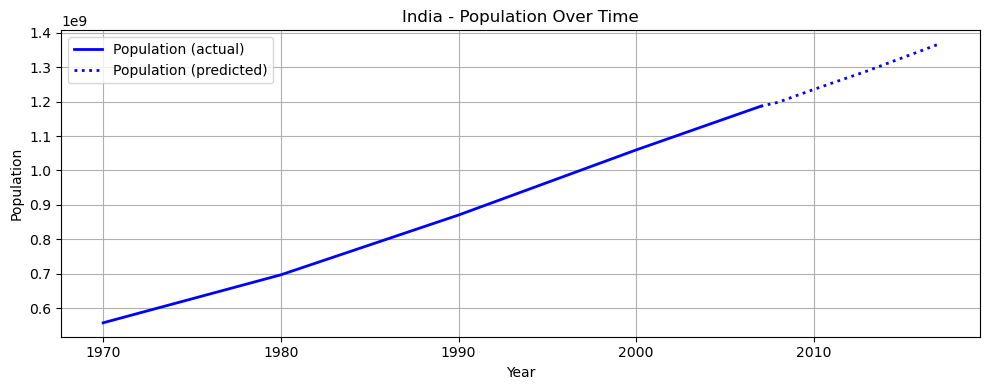

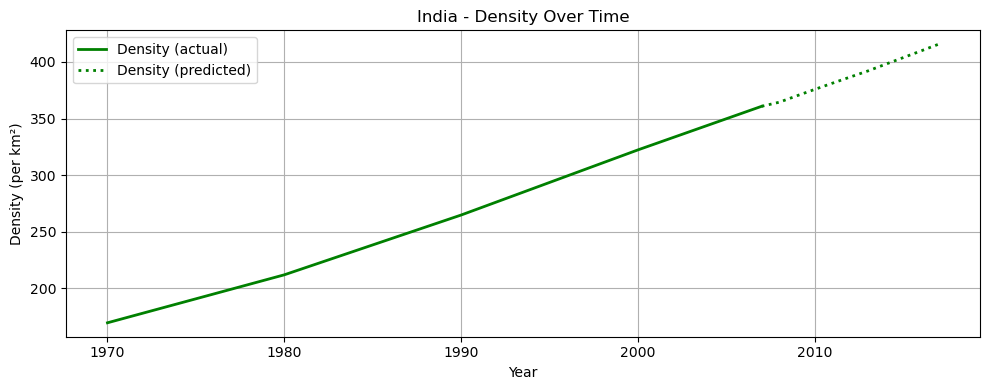

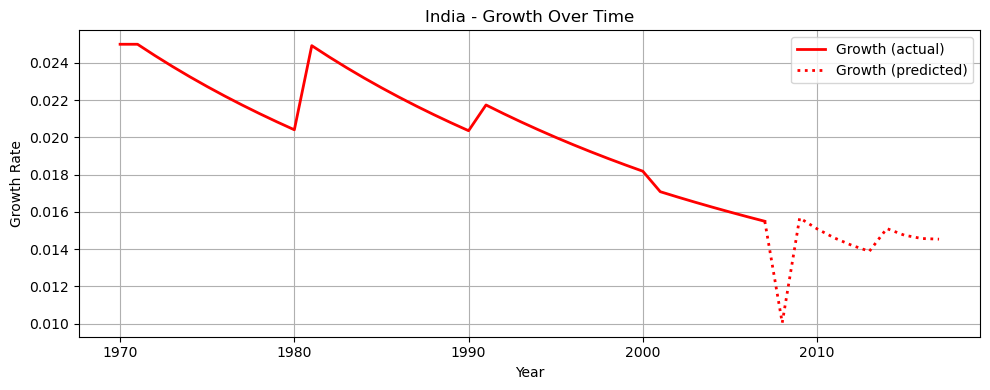

In [9]:
import matplotlib.pyplot as plt

# Filter India data
india_df = df_merged[df_merged['Country/Territory'] == 'India'].sort_values(by='Year')
india_actual = india_df[india_df['Year'] <= 2007]
india_pred = india_df[india_df['Year'] >= 2007]

# Plot Population
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Population'], color='blue', label='Population (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Population'], color='blue', linestyle='dotted', label='Population (predicted)', linewidth=2)
plt.title('India - Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Density
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Density'], color='green', label='Density (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Density'], color='green', linestyle='dotted', label='Density (predicted)', linewidth=2)
plt.title('India - Density Over Time')
plt.xlabel('Year')
plt.ylabel('Density (per km²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Growth
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Growth'], color='red', label='Growth (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Growth'], color='red', linestyle='dotted', label='Growth (predicted)', linewidth=2)
plt.title('India - Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout

print(tf.config.list_physical_devices('GPU'))

# Parameters
seq_len = 5
n_future = 10

results = []

for country in df_filtered['Country/Territory'].unique():
    df_country = df_filtered[df_filtered['Country/Territory'] == country][['Year', 'Population', 'Area (km²)', 'Growth']].dropna()
    
    if len(df_country) <= seq_len:
        continue

    area = df_country['Area (km²)'].iloc[0]
    last_pop = df_country[df_country['Year'] == 2007]['Population'].values[0]

    # Scale Growth
    scaler = MinMaxScaler()
    growth_scaled = scaler.fit_transform(df_country[['Growth']])

    # Create sequences
    def create_sequences(data, seq_length=5):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(growth_scaled, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # LSTM model

    model = Sequential([
        LSTM(64, return_sequences=True, activation='tanh', input_shape=(seq_len, 1)),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Forecasting growth
    last_seq = growth_scaled[-seq_len:]
    growth_preds = []

    for _ in range(n_future):
        pred = model.predict(last_seq.reshape(1, seq_len, 1), verbose=0)[0][0]
        growth_preds.append(pred)
        last_seq = np.append(last_seq[1:], [[pred]], axis=0)

    growth_preds = scaler.inverse_transform(np.array(growth_preds).reshape(-1, 1)).flatten()

    # Calculate Population and Density using Growth
    populations = []
    densities = []
    pop = last_pop

    for g in growth_preds:
        pop = pop * (1 + g / 100)
        populations.append(pop)
        densities.append(pop / area)

    future_years = np.arange(2008, 2008 + n_future)
    df_future = pd.DataFrame({
        'Country/Territory': country,
        'Year': future_years,
        'Growth': growth_preds,
        'Population': populations,
        'Area (km²)': area,
        'Density': densities
    })

    results.append(df_future)

# Final combined dataframe
df_lstm2 = pd.concat(results, ignore_index=True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/home/saswata/miniconda3/envs/myenv2/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/saswata/miniconda3/envs/myenv2/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/saswata/miniconda3/envs/myenv2/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/saswata/miniconda3/envs/myenv2/lib/python3.10/site-package

In [11]:
df_lstm2

,Country/Territory,Year,Growth,Population,Area (km²),Density
0,Afghanistan,2008,0.035681,2.560480e+07,652230.0,39.257314
1,Afghanistan,2009,0.034936,2.561374e+07,652230.0,39.271029
2,Afghanistan,2010,0.034377,2.562255e+07,652230.0,39.284529
3,Afghanistan,2011,0.033957,2.563125e+07,652230.0,39.297869
4,Afghanistan,2012,0.033647,2.563987e+07,652230.0,39.311092
...,...,...,...,...,...,...
2335,Zimbabwe,2013,0.008070,1.254434e+07,390757.0,32.102654
2336,Zimbabwe,2014,0.008056,1.254535e+07,390757.0,32.105241
2337,Zimbabwe,2015,0.008047,1.254636e+07,390757.0,32.107824
2338,Zimbabwe,2016,0.008040,1.254737e+07,390757.0,32.110405


In [12]:
import pandas as pd

# Step 1: Clean original full dataframe
df_full_cleaned = df_filtered.drop(columns=['Growth Rate', 'Date'])

# Step 2: Concatenate df_full_cleaned and df_lstm2
df_merged2 = pd.concat([df_full_cleaned, df_lstm2], ignore_index=True)

# Step 3: Sort by country and year
df_merged2.sort_values(by=['Country/Territory', 'Year'], inplace=True)
df_merged2.reset_index(drop=True, inplace=True)


In [13]:
df_merged2.iloc[40:70]

,Year,Country/Territory,Area (km²),Population,Density,Growth
40,2010,Afghanistan,652230.0,2.562255e+07,39.284529,0.034377
41,2011,Afghanistan,652230.0,2.563125e+07,39.297869,0.033957
42,2012,Afghanistan,652230.0,2.563987e+07,39.311092,0.033647
43,2013,Afghanistan,652230.0,2.564844e+07,39.324233,0.033430
44,2014,Afghanistan,652230.0,2.565694e+07,39.337256,0.033115
45,2015,Afghanistan,652230.0,2.566537e+07,39.350184,0.032864
46,2016,Afghanistan,652230.0,2.567375e+07,39.363033,0.032653
47,2017,Afghanistan,652230.0,2.568209e+07,39.375813,0.032469
48,1970,Albania,28748.0,2.324731e+06,80.865834,0.026537
49,1971,Albania,28748.0,2.386423e+06,83.011792,0.026537


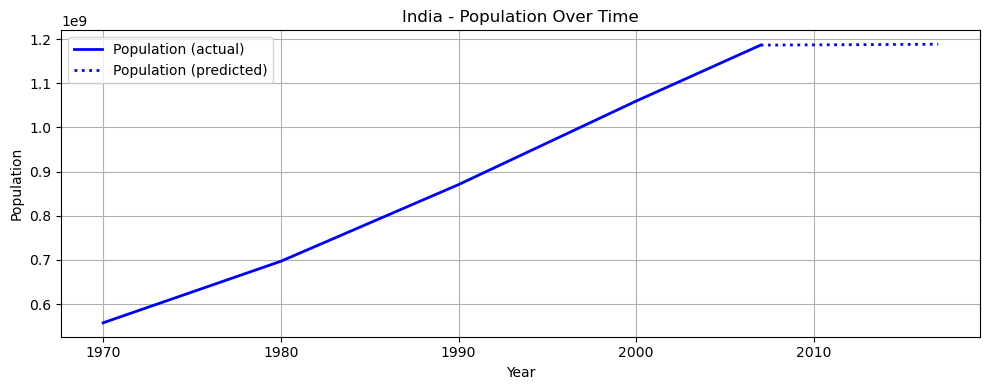

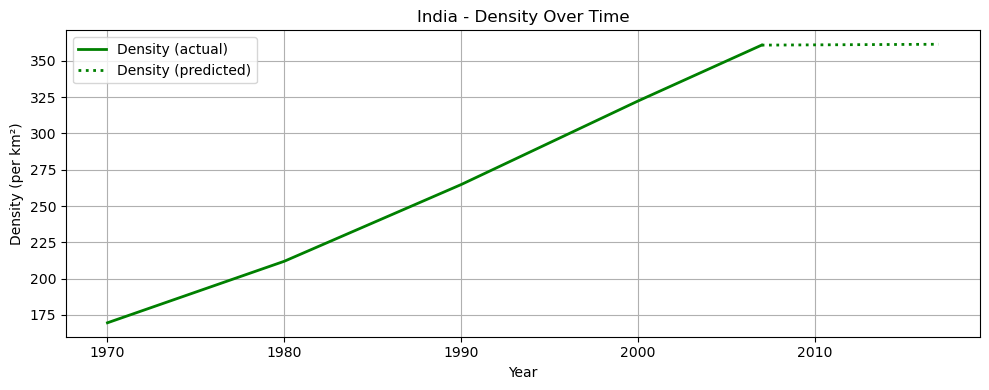

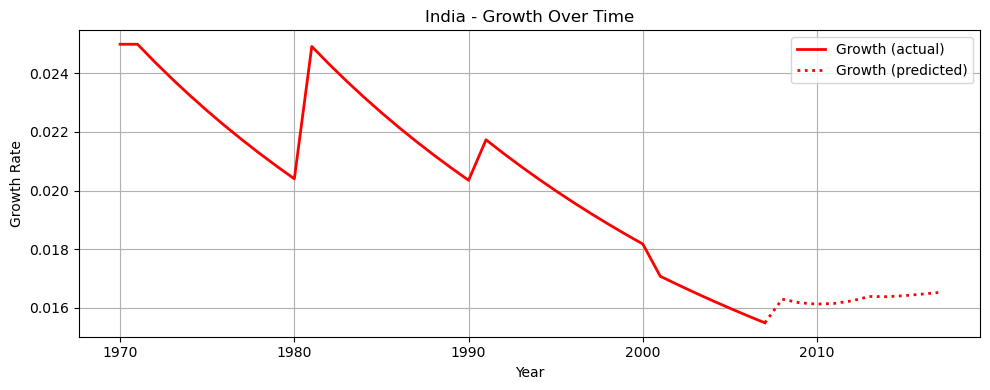

In [14]:
import matplotlib.pyplot as plt

# Filter India data
india_df = df_merged2[df_merged2['Country/Territory'] == 'India'].sort_values(by='Year')
india_actual = india_df[india_df['Year'] <= 2007]
india_pred = india_df[india_df['Year'] >= 2007]

# Plot Population
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Population'], color='blue', label='Population (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Population'], color='blue', linestyle='dotted', label='Population (predicted)', linewidth=2)
plt.title('India - Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Density
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Density'], color='green', label='Density (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Density'], color='green', linestyle='dotted', label='Density (predicted)', linewidth=2)
plt.title('India - Density Over Time')
plt.xlabel('Year')
plt.ylabel('Density (per km²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Growth
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Growth'], color='red', label='Growth (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Growth'], color='red', linestyle='dotted', label='Growth (predicted)', linewidth=2)
plt.title('India - Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define evaluation function
def evaluate_predictions(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# Store scores
evaluation_results_lstm_merged = []
evaluation_results_lstm_merged2 = []

# LSTM Model 1 Comparison (df_merged = actual)
for country in df_merged['Country/Territory'].unique():
    # Filter predicted data for LSTM model 1 (df_merged)
    pred_df = df_merged[(df_merged['Country/Territory'] == country) &
                        (df_merged['Year'].between(2008, 2017))]
    
    # Get actual values from df_full
    actual_df = df_full[(df_full['Country/Territory'] == country) &
                        (df_full['Year'].between(2008, 2017))]

    if not len(pred_df) or not len(actual_df):
        continue

    pred_df = pred_df.sort_values(by='Year')
    actual_df = actual_df.sort_values(by='Year')

    for col in ['Population', 'Growth', 'Density']:
        metrics = evaluate_predictions(actual_df[col].values, pred_df[col].values)
        metrics.update({
            'Model': 'LSTM_merged',
            'Country': country,
            'Feature': col
        })
        evaluation_results_lstm_merged.append(metrics)

# LSTM Model 2 Comparison (df_merged2 = actual)
for country in df_merged2['Country/Territory'].unique():
    # Filter predicted data for LSTM model 2 (df_merged2)
    pred_df = df_merged2[(df_merged2['Country/Territory'] == country) &
                         (df_merged2['Year'].between(2008, 2017))]
    
    # Get actual values from df_full
    actual_df = df_full[(df_full['Country/Territory'] == country) &
                        (df_full['Year'].between(2008, 2017))]

    if not len(pred_df) or not len(actual_df):
        continue

    pred_df = pred_df.sort_values(by='Year')
    actual_df = actual_df.sort_values(by='Year')

    for col in ['Population', 'Growth', 'Density']:
        metrics = evaluate_predictions(actual_df[col].values, pred_df[col].values)
        metrics.update({
            'Model': 'LSTM_merged2',
            'Country': country,
            'Feature': col
        })
        evaluation_results_lstm_merged2.append(metrics)

# Combine results from both LSTM models
eval_df_combined = pd.concat([pd.DataFrame(evaluation_results_lstm_merged), 
                              pd.DataFrame(evaluation_results_lstm_merged2)], ignore_index=True)

# Optionally: save results to CSV
# eval_df_combined.to_csv('lstm_model_comparison_metrics.csv', index=False)

# Display the combined evaluation DataFrame
eval_df_combined.head()



,MAE,MSE,RMSE,R2,MAPE,Model,Country,Feature
0,6.370635e+06,5.406339e+13,7.352781e+06,-4.773771,19.576611,LSTM_merged,Afghanistan,Population
1,3.222370e-02,1.181771e-03,3.437690e-02,-135.779359,94.776476,LSTM_merged,Afghanistan,Growth
2,9.767466e+00,1.270872e+02,1.127329e+01,-4.773770,19.576611,LSTM_merged,Afghanistan,Density
3,2.141316e+05,4.772843e+10,2.184684e+05,-62.163407,7.385105,LSTM_merged,Albania,Population
4,9.025509e-03,2.380336e-04,1.542834e-02,-20.428383,230.468628,LSTM_merged,Albania,Growth


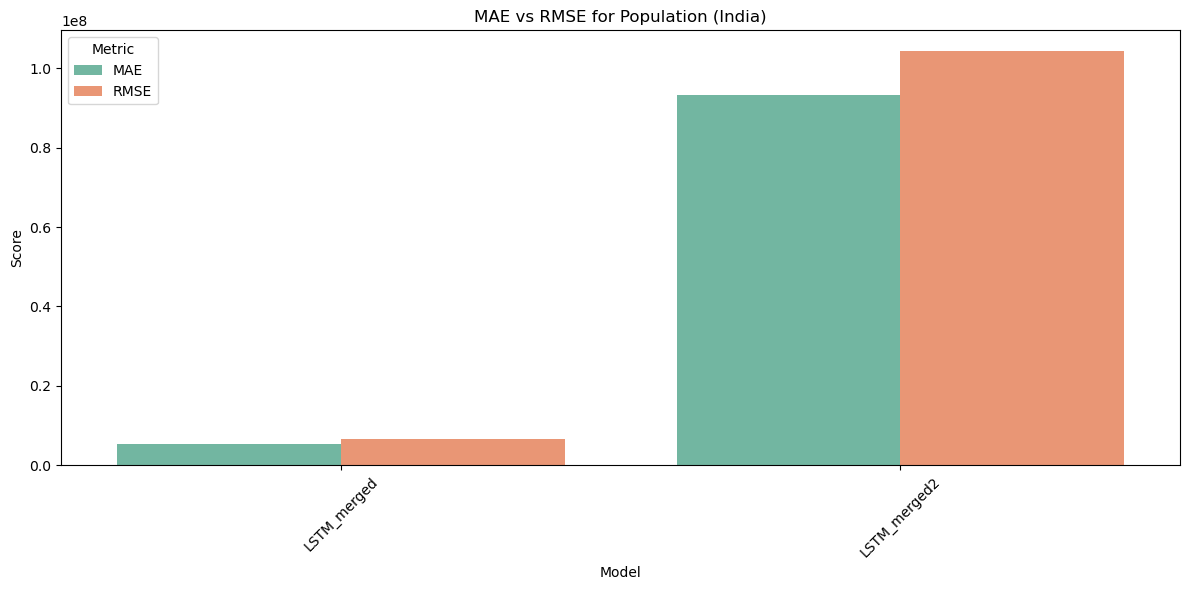

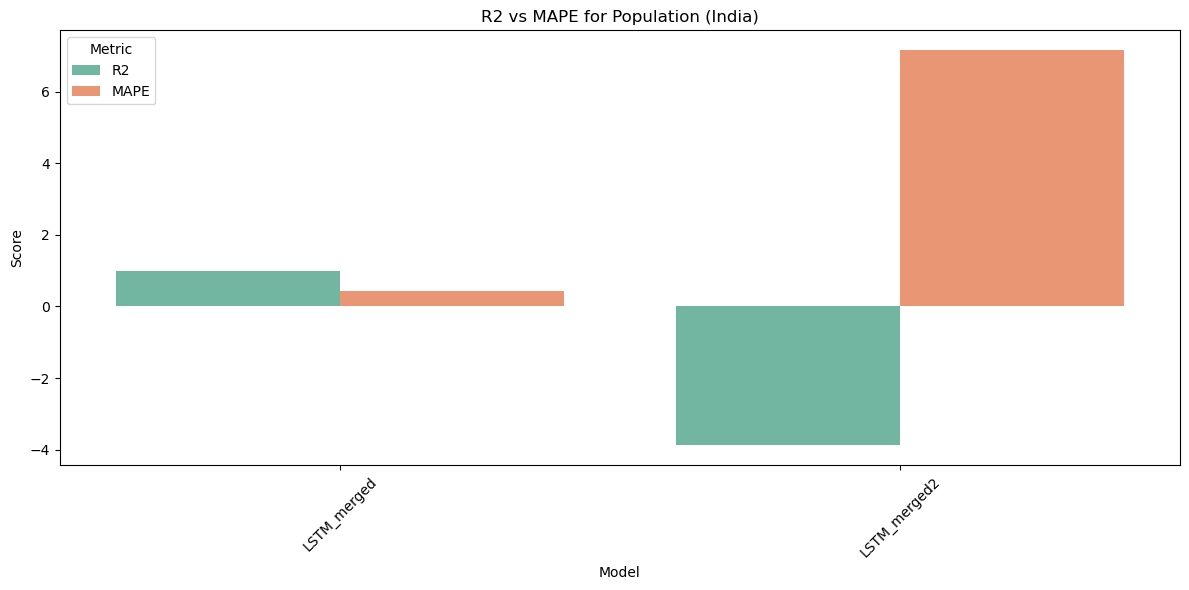

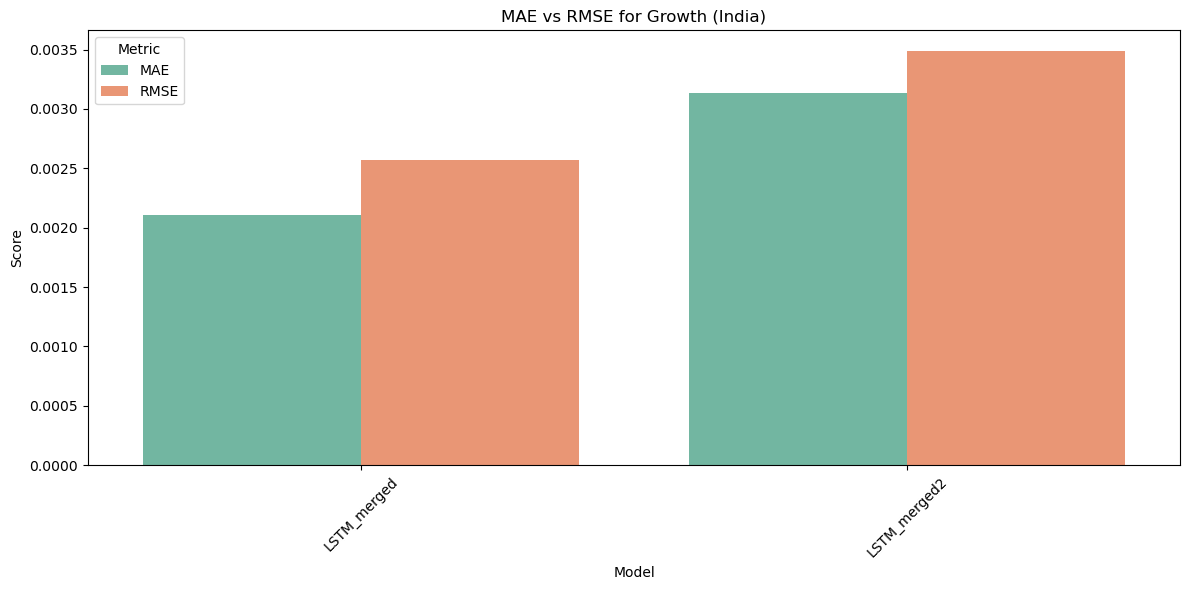

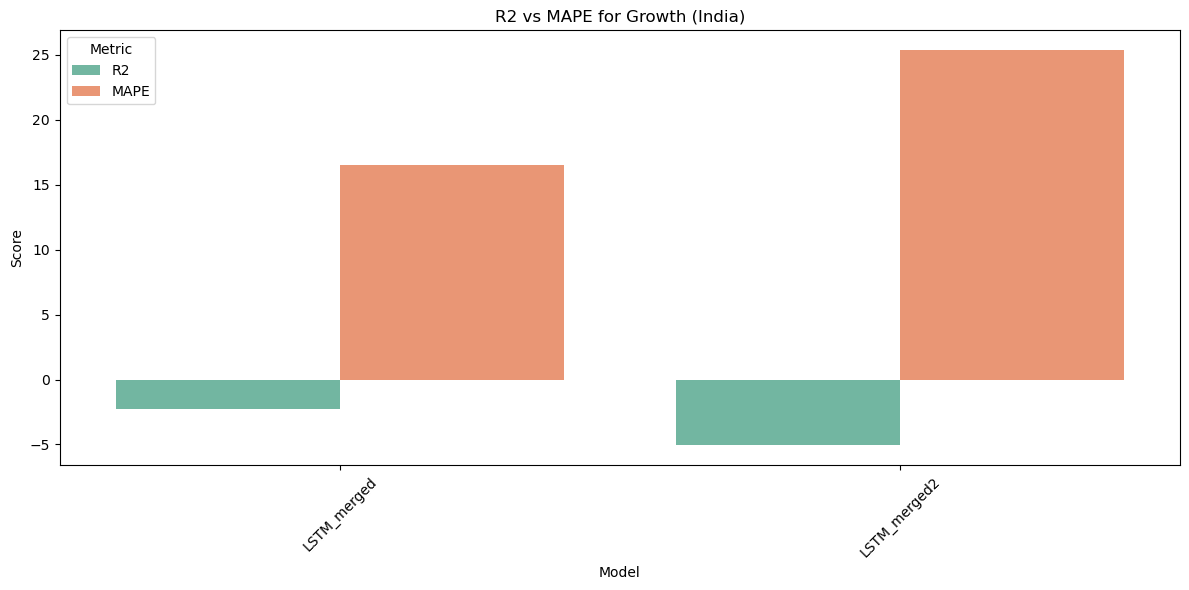

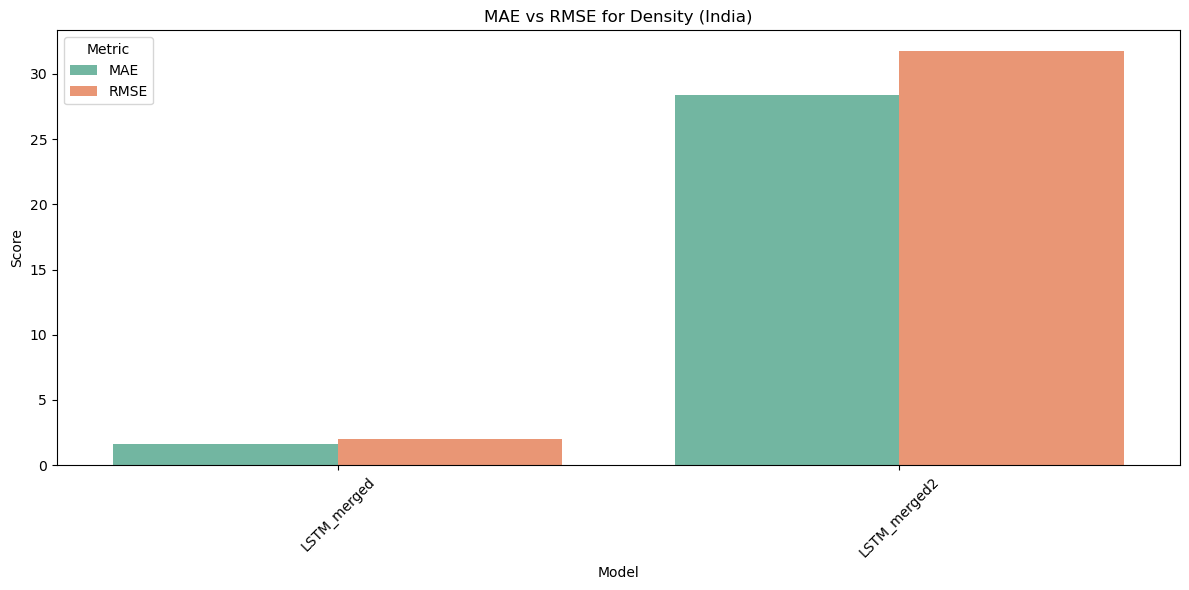

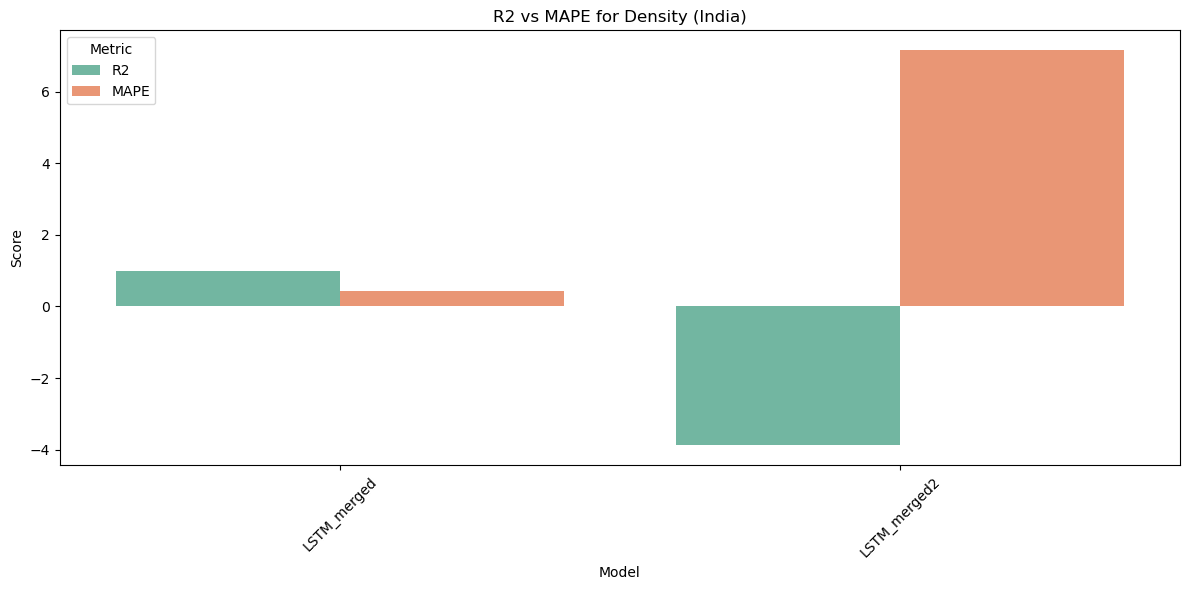

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for India
india_scores = eval_df_combined[eval_df_combined['Country'] == 'India']

# Plot configs
metric_groups = {
    'MAE_RMSE': ['MAE', 'RMSE'],
    'R2_MAPE': ['R2', 'MAPE']
}

# For each feature
for feature in ['Population', 'Growth', 'Density']:
    feature_df = india_scores[india_scores['Feature'] == feature]
    
    for group_name, metrics in metric_groups.items():
        melted_df = feature_df.melt(id_vars=['Model'], value_vars=metrics, 
                                    var_name='Metric', value_name='Score')

        plt.figure(figsize=(12, 6))
        sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df, palette='Set2')
        plt.title(f'{group_name.replace("_", " vs ")} for {feature} (India)')
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(title='Metric')
        plt.tight_layout()
        plt.show()
